# Skin Cancer Binary Image Classification

In [126]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import cv2

### Loading and Processing Data

Found 2637 files belonging to 2 classes.


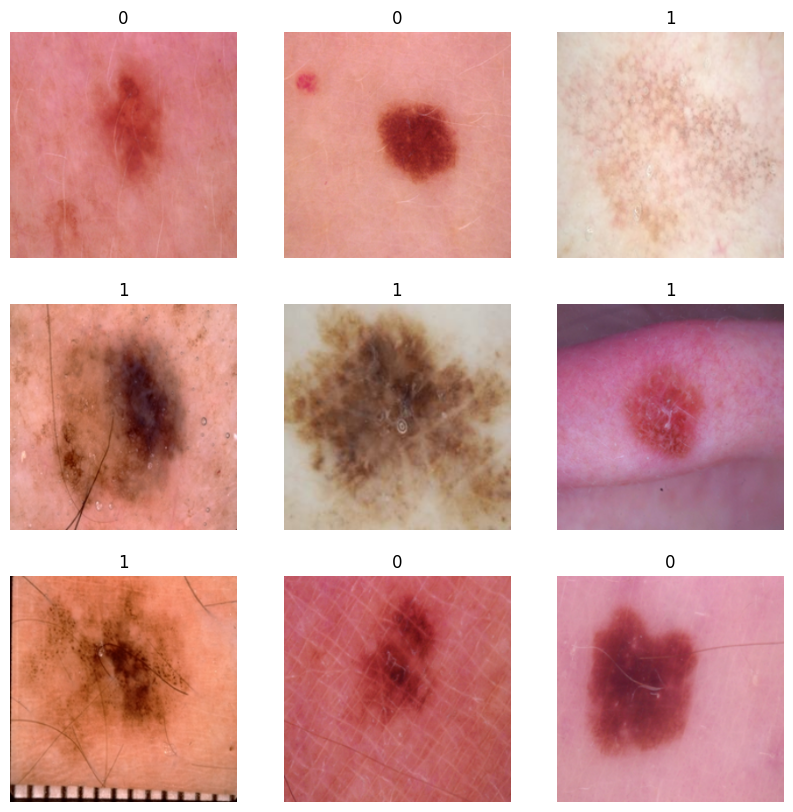

Training Size: 67
Validation Size: 16


In [136]:
data = tf.keras.utils.image_dataset_from_directory(os.path.join('data', 'train'))

# Displaying 9 images
for images, labels in data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()

# Normalizing pixel values
data = data.map(lambda x, y: (x / 255, y))

# Splitting into training and validation
training_size = int(len(data)*.8) + 1 # didn't divide evenly
validation_size = int(len(data)*.2)
training = data.take(training_size)
validation = data.skip(training_size).take(validation_size)

print(f'Training Size: {training_size}')
print(f'Validation Size: {validation_size}')

# 0 - benign
# 1 - malignant

### Constructing Model

In [137]:
model = Sequential()

# Input layer
model.add(Input(shape=(256, 256, 3)))

# Convolutional and MaxPooling layers with Dropout
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())

# Fully connected layers with Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

# Callbacks: Early stopping, Learning rate scheduler, and TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
tensorboard_callback = TensorBoard(log_dir='logs')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,396,641 (28.22 MB)

 Trainable params: 7,396,641 (28.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [138]:
hist = model.fit(
    training, 
    epochs=25, 
    validation_data=validation, 
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]
)

Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.5292 - loss: 1.5152 - val_accuracy: 0.5943 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.5962 - loss: 0.6889 - val_accuracy: 0.5842 - val_loss: 0.6706 - learning_rate: 0.0010
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.5577 - loss: 0.6419 - val_accuracy: 0.6308 - val_loss: 0.5471 - learning_rate: 0.0010
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.7013 - loss: 0.5398 - val_accuracy: 0.7647 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.7735 - loss: 0.4761 - val_accuracy: 0.7911 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.7960 - loss: 0.4273 - val_accuracy: 0.7911 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.7999 - loss: 0.

### Loss and Accuracy Plots

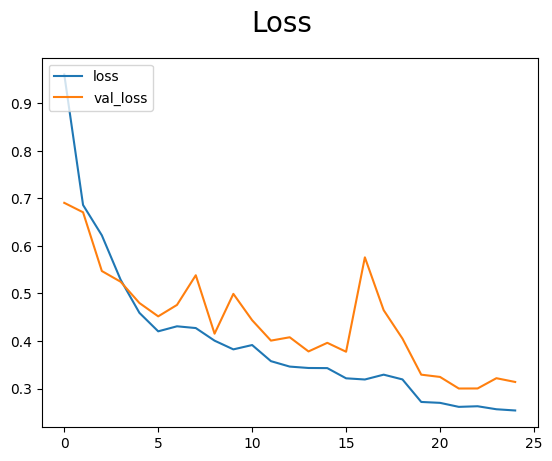

In [143]:
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

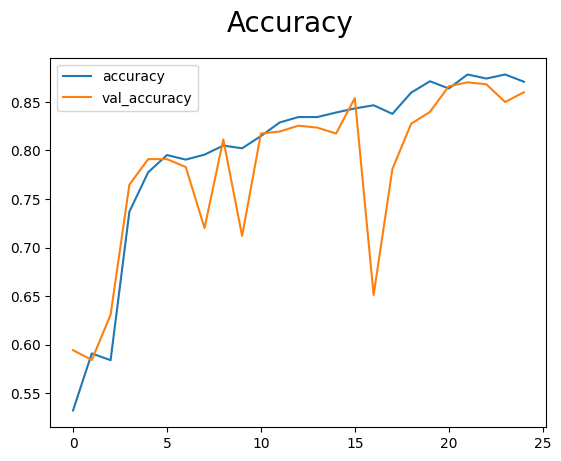

In [145]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Testing

In [167]:
def process_display_and_predict(image_path, model):
    img = cv2.imread(image_path)
    img = tf.image.resize(img, (256, 256))
    
    plt.imshow(img.numpy().astype(int))
    plt.show()
    
    yhat = model.predict(np.expand_dims(img/255.0, axis=0))

    if yhat < .5:
        print(f'Predicted: {yhat[0][0]}, likely benign')
    else:
        print(f'Predicted: {yhat[0][0]}, potentially malignant')

#### Test Data

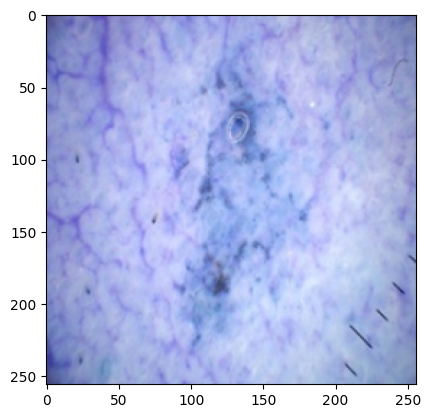

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: 0.5544767379760742, potentially malignant
Actual: Malignant


In [185]:
process_display_and_predict(os.path.join('data', 'test', 'malignant', '196.jpg'), model)
print('Actual: Malignant')

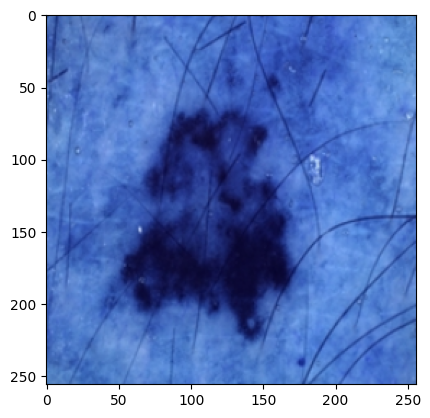

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted: 0.8242581486701965, potentially malignant
Actual: Malignant


In [186]:
process_display_and_predict(os.path.join('data', 'test', 'malignant', '390.jpg'), model)
print('Actual: Malignant')

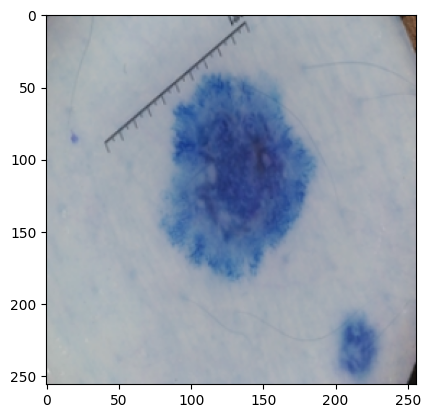

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: 0.5569158792495728, potentially malignant
Actual: Malignant


In [187]:
process_display_and_predict(os.path.join('data', 'test', 'malignant', '568.jpg'), model)
print('Actual: Malignant')

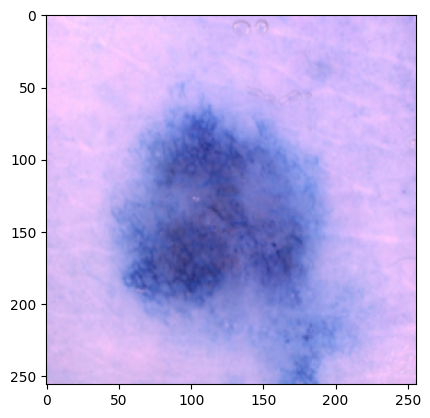

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: 0.386614054441452, likely benign
Actual: Benign


In [189]:
process_display_and_predict(os.path.join('data', 'test', 'benign', '10.jpg'), model)
print('Actual: Benign')

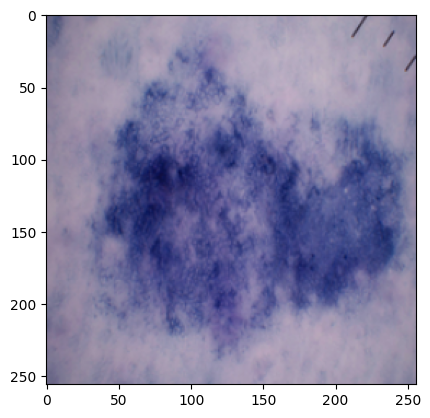

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted: 0.4979444742202759, likely benign
Actual: Benign


In [190]:
process_display_and_predict(os.path.join('data', 'test', 'benign', '273.jpg'), model)
print('Actual: Benign')

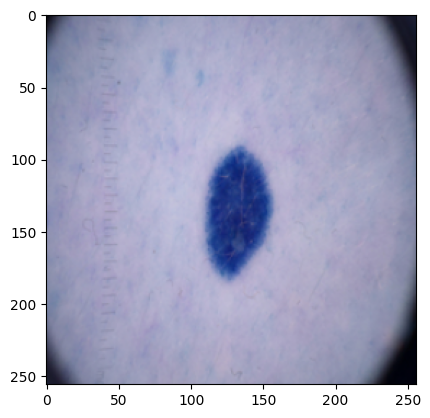

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted: 0.2581365704536438, likely benign
Actual: Benign


In [191]:
process_display_and_predict(os.path.join('data', 'test', 'benign', '906.jpg'), model)
print('Actual: Benign')

#### Images from Google

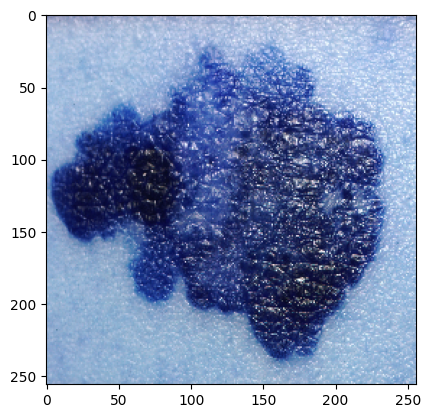

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted: 0.9644563794136047, potentially malignant
Actual: Malignant


In [192]:
process_display_and_predict(os.path.join('data', 'google_test', 'malignant', '1.jpg'), model)
print('Actual: Malignant')

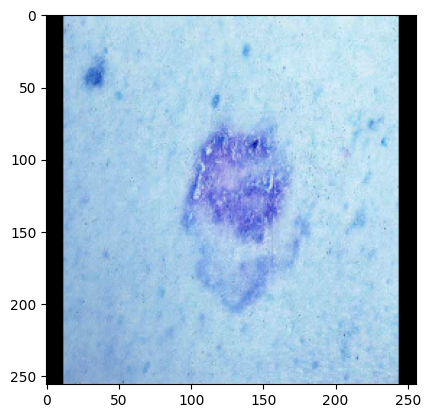

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted: 0.7564572691917419, potentially malignant
Actual: Malignant


In [193]:
process_display_and_predict(os.path.join('data', 'google_test', 'malignant', '2.jpg'), model)
print('Actual: Malignant')

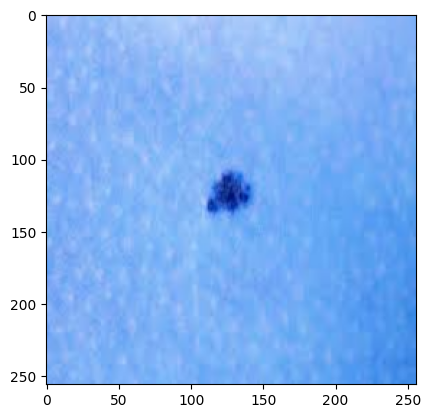

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: 0.2769784927368164, likely benign
Actual: Benign


In [194]:
process_display_and_predict(os.path.join('data', 'google_test', 'benign', '1.jpg'), model)
print('Actual: Benign')

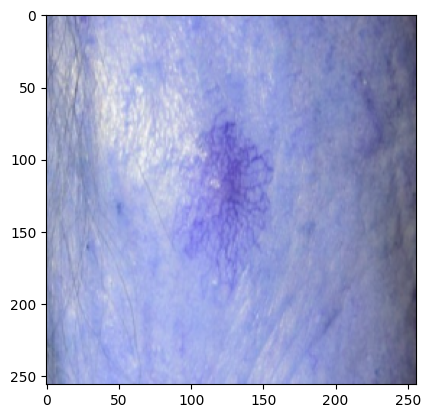

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted: 0.5497386455535889, potentially malignant
Actual: Benign


In [195]:
process_display_and_predict(os.path.join('data', 'google_test', 'benign', '2.jpg'), model)
print('Actual: Benign')

In [124]:
model.save(os.path.join('models', 'model1.h5'))
model.save(os.path.join('models', 'model1.keras'))